# Smart energy forecasting  
## Notebook 2 – Temporal analysis  

This notebook performs an in-depth temporal analysis of the cleaned French electricity load dataset.  
It explores daily, weekly, and annual patterns to understand seasonality, working-hour effects, and long-term trends.

### Objectives
- Load the cleaned dataset (`energy_france.csv`)
- Explore overall trends and seasonality
- Analyze average load by hour, day, and month
- Create advanced visualizations (heatmap, boxplot, decomposition)
- Summarize key insights for modeling


## Load the cleaned dataset
We start by importing the cleaned data produced in the previous notebook (`01_data_preparation.ipynb`) and we ensure the `datetime` column is parsed with the `Europe/Paris` timezone..


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv("../data/energy_france.csv", parse_dates=["datetime"])
df["datetime"] = pd.to_datetime(df["datetime"], utc=True).dt.tz_convert("Europe/Paris")
df = df.sort_values("datetime").reset_index(drop=True)

print("Data loaded successfully")
print(df.info())
df.head()


Data loaded successfully
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50357 entries, 0 to 50356
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype                       
---  ------    --------------  -----                       
 0   datetime  50357 non-null  datetime64[ns, Europe/Paris]
 1   load_mw   50357 non-null  float64                     
dtypes: datetime64[ns, Europe/Paris](1), float64(1)
memory usage: 787.0 KB
None


,datetime,load_mw
0,2015-01-01 02:00:00+01:00,69773.0
1,2015-01-01 03:00:00+01:00,66417.0
2,2015-01-01 04:00:00+01:00,64182.0
3,2015-01-01 05:00:00+01:00,63859.0
4,2015-01-01 06:00:00+01:00,63921.0



## Basic checks
Check date range, missing values, and general statistics.


In [4]:

print("Date range:", df["datetime"].min(), "to", df["datetime"].max())
print("Number of rows:", len(df))
print("Missing values:", df.isna().sum().sum())
print("Max load (MW):", df["load_mw"].max())
print("Min load (MW):", df["load_mw"].min())


Date range: 2015-01-01 02:00:00+01:00 to 2020-10-01 00:00:00+02:00
Number of rows: 50357
Missing values: 0
Max load (MW): 158000.0
Min load (MW): 29398.0



## Overall trend visualization
Let's visualize the overall electricity load evolution between 2015 and 2020.
 
A global plot helps spot long-term behavior, strong seasonality, and any large anomalies.



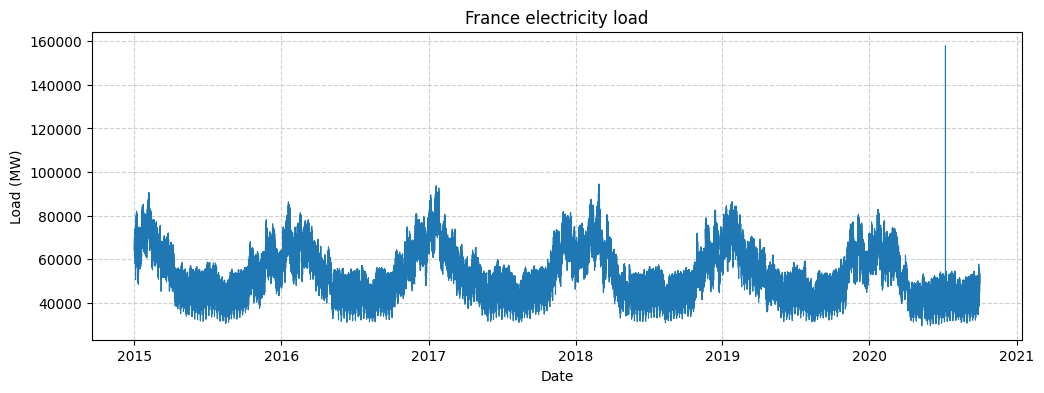

In [5]:

plt.figure(figsize=(12, 4))
plt.plot(df["datetime"], df["load_mw"], linewidth=0.8)
plt.title("France electricity load")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



**Interpretation:** The series exhibits pronounced winter peaks and summer troughs.  
The shape is typical of heating-driven systems and motivates focusing on calendar effects.



## Hourly, daily, and monthly patterns
We now analyze consumption by hour, day of the week, and month.


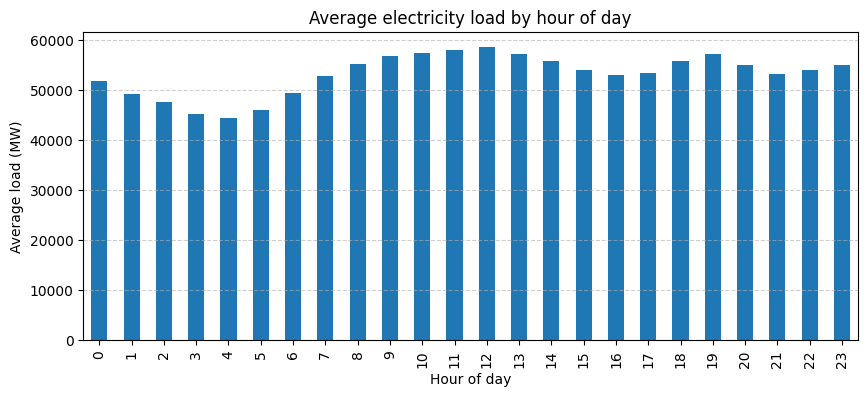

In [6]:

# Hourly average
hourly_avg = df.groupby(df["datetime"].dt.hour)["load_mw"].mean()
plt.figure(figsize=(10, 4))
hourly_avg.plot(kind="bar")
plt.title("Average electricity load by hour of day")
plt.xlabel("Hour of day")
plt.ylabel("Average load (MW)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


**Interpretation (hourly):** Demand is lowest during the night (2-5 a.m.), ramps up after 6 a.m., and peaks during working hours. A smaller evening rebound reflects household routines.


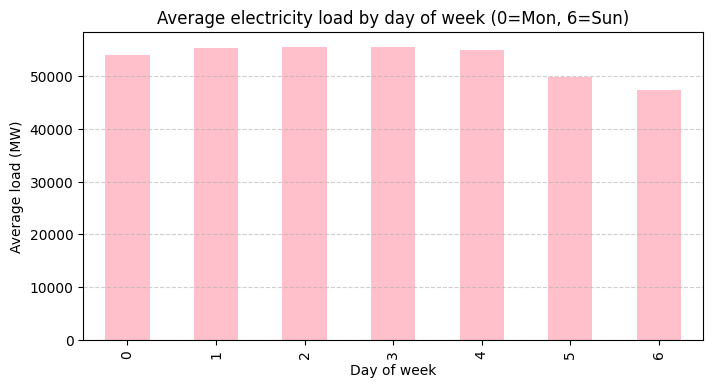

In [7]:
# Day of week average
daily_avg = df.groupby(df["datetime"].dt.dayofweek)["load_mw"].mean()
plt.figure(figsize=(8, 4))
daily_avg.plot(kind="bar", color="pink")
plt.title("Average electricity load by day of week (0=Mon, 6=Sun)")
plt.xlabel("Day of week")
plt.ylabel("Average load (MW)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


**Interpretation (day of week):** Weekdays show higher demand due to industrial/commercial activity, while weekends (especially Sundays) are lower.

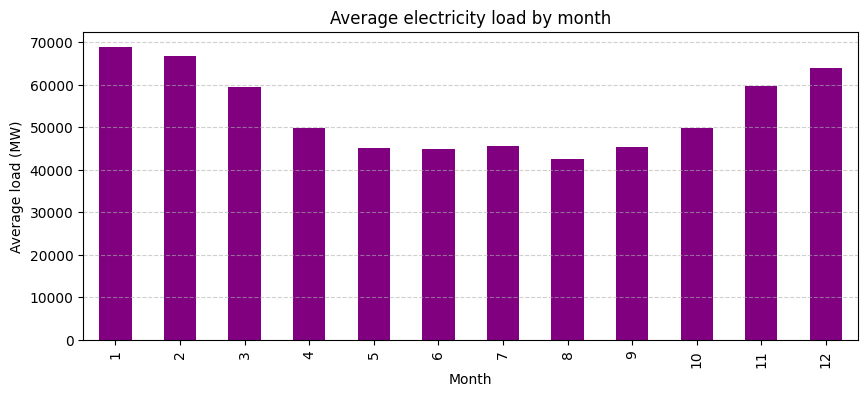

In [8]:
# Monthly average
monthly_avg = df.groupby(df["datetime"].dt.month)["load_mw"].mean()
plt.figure(figsize=(10, 4))
monthly_avg.plot(kind="bar", color="purple")
plt.title("Average electricity load by month")
plt.xlabel("Month")
plt.ylabel("Average load (MW)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


**Interpretation (month):** Strong winter–summer contrast: Jan-Feb peak (heating) vs Jun–Aug trough. 


## Advanced temporal visualizations
We will visualize deeper temporal structures with:
1. Heatmap (day × hour)
2. Boxplot (month)
3. Seasonal decomposition


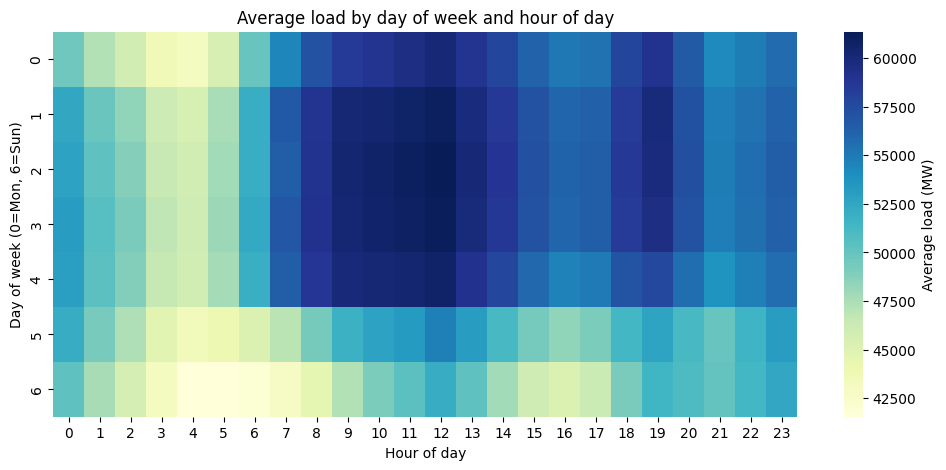

In [9]:

# Heatmap
pivot = df.pivot_table(
    index=df["datetime"].dt.dayofweek,
    columns=df["datetime"].dt.hour,
    values="load_mw",
    aggfunc="mean"
)
plt.figure(figsize=(12, 5))
sns.heatmap(pivot, cmap="YlGnBu", cbar_kws={'label': 'Average load (MW)'})
plt.title("Average load by day of week and hour of day")
plt.xlabel("Hour of day")
plt.ylabel("Day of week (0=Mon, 6=Sun)")
plt.show()


Darker cells correspond to higher average demand. Weekdays show strong daytime bands; nights and weekends are lighter. This view combines both daily and weekly cycles.


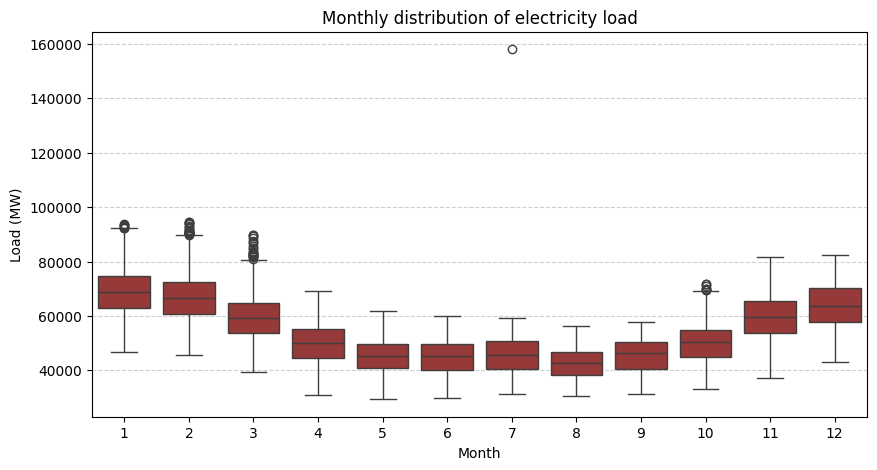

In [10]:

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["datetime"].dt.month, y=df["load_mw"], color="brown")
plt.title("Monthly distribution of electricity load")
plt.xlabel("Month")
plt.ylabel("Load (MW)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


**Interpretation (boxplot):** Winter months have higher medians and wider spreads (weather-sensitive), while summer is lower and more stable. Outliers may indicate extreme weather or reporting quirks.


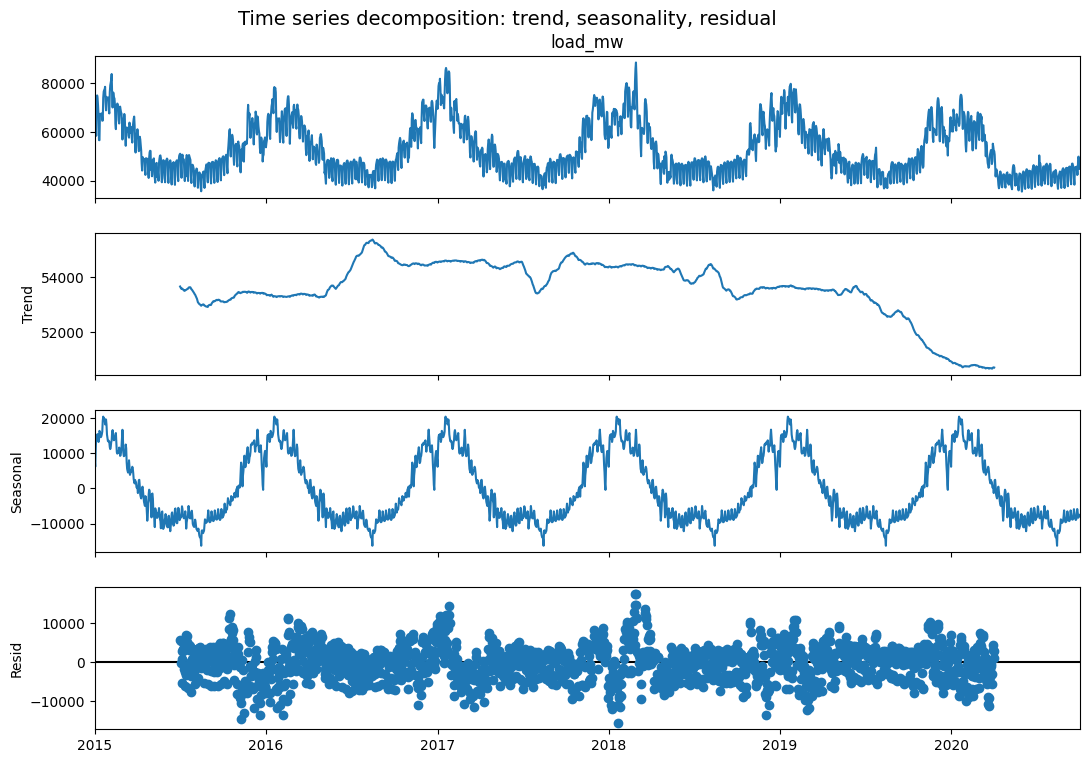

In [11]:

# Decomposition
df_daily = df.set_index("datetime").resample("D")["load_mw"].mean()
decomposition = seasonal_decompose(df_daily, model="additive", period=365)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Time series decomposition: trend, seasonality, residual", fontsize=14)
plt.show()



**Decomposition:**  
- **Trend:** slow-moving baseline across years.  
- **Seasonality:** repeating annual cycle (winter peaks, summer troughs).  
- **Residuals:** short-term fluctuations not explained by trend/seasonality.  
This confirms that most structure is calendar-driven, guiding feature engineering.
